In [1]:
## READ DATA ##
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

def get_data(min,max):
    ##
    df = (pd.read_csv('./MLParamDataJan312020_Linear_Filtered_66.6ms.csv')[min:max])#[0:200000])#00])
    df['B:VIMIN_MEAN'] = df['B:VIMIN'].rolling(window=15).mean()
    df['B:VIMIN_STD'] = df['B:VIMIN'].rolling(window=15).std()
    df = df.dropna()
    print(df.shape)
    return df

df = get_data(0,-1)

(7263, 27)


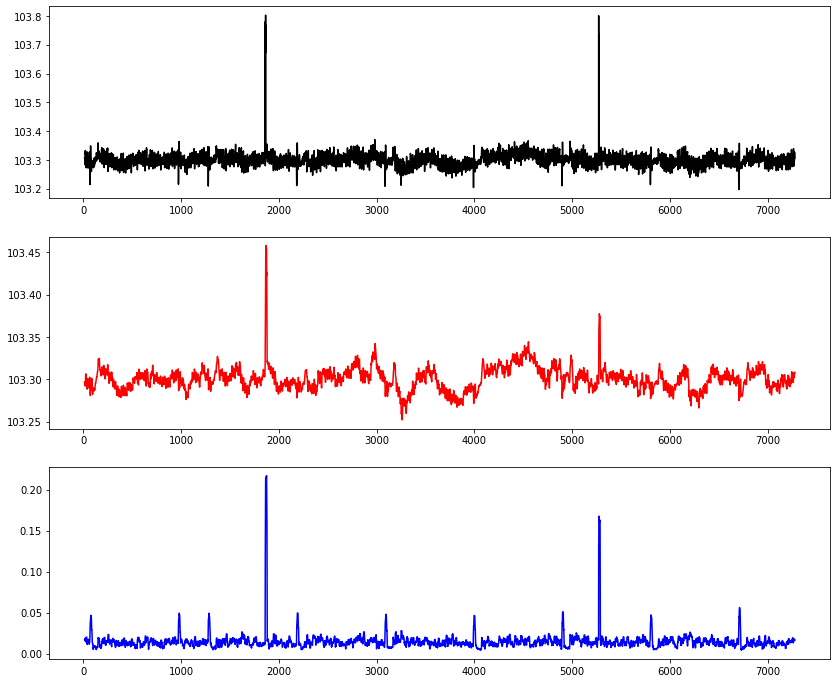

In [2]:
## NORMALIZE DATA ##
fig, axs = plt.subplots(3,figsize=(14,12))
value = axs[0].plot(df['B:VIMIN'][0:10000], color='black', label='Resampled values')
mean = axs[1].plot(df['B:VIMIN_MEAN'][0:10000], color='red', label='Rolling Mean')
std = axs[2].plot(df['B:VIMIN_STD'][0:10000], color='blue', label='Rolling Std')

In [3]:
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
dataset = df['B:VIMIN_MEAN'].values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

## TODO: Fix
print(len(dataset))
train_size = int(len(dataset) * 0.73)
print(train_size)
test_size = len(dataset) - train_size
print(test_size)

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1,look_forward=1):
    X, Y = [], []
    offset = look_back+look_forward
    for i in range(len(dataset)-(offset+1)):
        xx = dataset[i:(i+look_back), 0]
        yy = dataset[(i + look_back):(i + offset), 0]
        #yy = dataset[i:(i+look_back), 0]
        #yy = dataset[(i + look_back), 0]
        X.append(xx)
        Y.append(yy)
    return np.array(X), np.array(Y)

look_back    = 2000 
look_forward = 200 ## 1 second (cycle - 15Hz)

X_train, Y_train = create_dataset(train, look_back,look_forward)
X_test, Y_test = create_dataset(test, look_back,look_forward)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
#X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
Y_train = np.reshape(Y_train, (Y_train.shape[0],  Y_train.shape[1]))
#Y_test = np.reshape(Y_test, (Y_test.shape[0],  Y_test.shape[1]))


7263
5301
1962


In [4]:
import keras 
from keras.optimizers import  SGD, Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GaussianNoise
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
keras.backend.clear_session()
model = Sequential()
model.add(LSTM(256, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GaussianNoise(0.1))
#model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(GaussianNoise(0.1))
#model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(GaussianNoise(0.1))
model.add(Dense(look_forward))
opt = Adam(lr=1e-4)
model.compile(loss='mean_squared_error', optimizer=opt)
model.summary()

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, min_lr=1e-6,verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=False)

history = model.fit(X_train, Y_train, epochs=50, batch_size=25, validation_split=0.2,
                    callbacks=[reduce_lr], verbose=1, shuffle=True)

Using TensorFlow backend.








_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 256)            2311168   
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 1, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 256)            525312    
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 1, 256)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               51400     
Tota

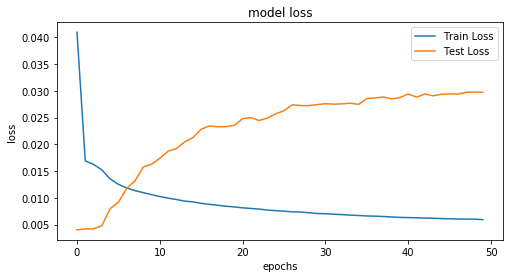

In [5]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [6]:
X_test = X_train
Y_test = Y_train
test_predict = model.predict(X_test)

(3100, 1, 2000)
(3100, 200)
(3100, 200)
ntest_samples: 3100


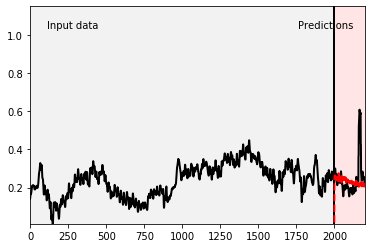

In [7]:
ntest_samples = len(X_test)
print(X_test.shape)
print(Y_test.shape)
print(test_predict.shape)
print('ntest_samples:',ntest_samples)
#fig, axs = plt.subplots(2,figsize=(24,20))
for i in range(ntest_samples):#ntest_samples-look_forward):
    plt.clf()
    #c_step = (i)*look_back
    #n_step = (i+1)*look_back
    #print('i',i)
    #print('c_step',c_step)
    #print('n_step',n_step)
    this_tx = np.concatenate((X_test[i][0].flatten(), Y_test[i].flatten()), axis=0)#[0:look_back+look_forward]
    #print(this_tx.shape)
    offset = X_test[i][0].copy()
    offset[:] = 0
    this_px = np.concatenate((offset.flatten(), test_predict[i].flatten()), axis=0)#[0:look_back+look_forward]
    plt.axvline(x=look_back,color='black',linewidth=2)
    plt.plot(this_tx, color='black',label='data',linewidth=2)
    plt.plot(this_px, '--', color='red',label='data+prediction',linewidth=2)
    plt.xlim(int(0),look_back+look_forward)
    plt.ylim(0.01,1.15)
    plt.axvspan(0, look_back, alpha=0.10, color='gray')
    plt.axvspan(look_back, look_back+look_forward, alpha=0.10, color='red')
    plt.annotate('Input data', xy=(0.05, 0.9), xycoords='axes fraction')
    plt.annotate('Predictions', xy=(0.8, 0.9), xycoords='axes fraction')
    ## Diff
    #this_px_diff = np.concatenate((X_test[c_step][0].flatten(), test_predict[c_step].flatten()), axis=0)[0:look_back+look_forward]
    #diff = this_px_diff - this_tx 
    plt.savefig('test_results/test_prediction_{}.png'.format(i))